### Imports

In [11]:

import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

### Preparing a toy dataset 

In [12]:
####################
## DATASET 
####################

#Genrate data
data = np.genfromtxt('perceptron_toydata.txt' , delimiter = '\t')

#Store into variables , the X and y 
X, y = data[: , :2] , data[ : ,2]
y = y.astype(int)

#Print the info about data 
print('Class label counts : ' , np.bincount(y))
print('X.shape' , X.shape)
print('y.shape' , y.shape)

#Shuffling and train-test division
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X , y = X[shuffle_idx] , y[shuffle_idx]

X_train , y_train = X[shuffle_idx[ :70]] , y[shuffle_idx[ :70]]
X_test , y_test = X[shuffle_idx[70: ]] , y[shuffle_idx[70:]]

#NOrmalize the data 
mu, sigma =  X_train.mean(axis = 0) , X_train.std(axis = 0)
X_train = (X_train - mu)/sigma 
X_test = (X_test - mu)/sigma 

Class label counts :  [50 50]
X.shape (100, 2)
y.shape (100,)


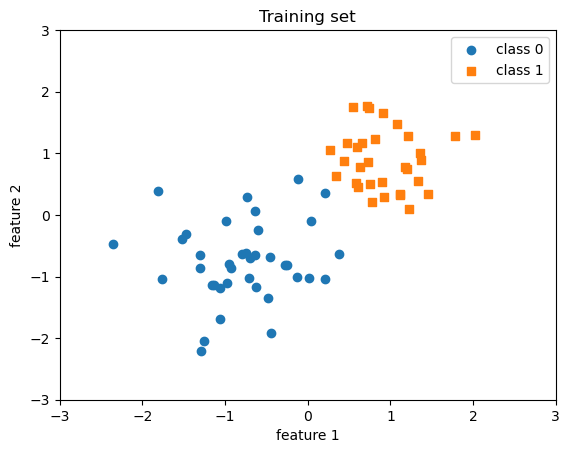

In [14]:
###Making scatter plot of training data 
plt.scatter(X_train[y_train==0 , 0] , X_train[y_train==0 , 1] , label = 'class 0' , marker = 'o')
plt.scatter(X_train[y_train==1 ,0] , X_train[y_train ==1 ,1] , label = 'class 1' , marker = 's')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3,3])
plt.ylim([-3,3]) 
plt.legend()
plt.show()


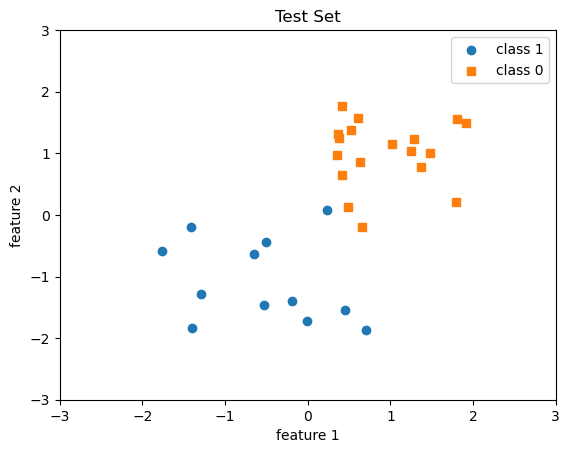

In [15]:
##Plotting the test set 
plt.scatter(X_test[y_test==0, 0] , X_test[y_test==0 , 1] , label = 'class 1' , marker = 'o')
plt.scatter(X_test[y_test==1, 0] , X_test[y_test==1 , 1] , label='class 0' , marker = 's')
plt.title('Test Set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend()
plt.show()

### Defining the Perceptron model

In [23]:
##Check if GPU is available ,else run on CPU 
device = torch.device('cuda.0' if torch.cuda.is_available() else 'cpu')

class Perceptron():
    
    ##Contrustor, called each time when new instance is created 
    def __init__(self,num_features):
        self.num_features = num_features
        
        ##Refer to Raschka's cheatsheet on numpy to  PyTorch datatype equivalents(Lec4 slides)
        self.weights = torch.zeros(num_features , 1, dtype= torch.float32 , device = device) # empty column vector 
        self.bias = torch.zeros( 1 , dtype = torch.float32 , device = device) # empty scalar 
        
        ##placeholder vectors so they don't need to be recreated each time 
        self.ones = torch.ones(1)
        self.zeros = torch.zeros(1)
        #We need these scalrs for classifciation , see the forward method! 
        
    def forward(self , x): 
        linear = torch.add(torch.mm(x , self.weights) , self.bias)  #x^Tw + bias : which is basically net input 
        predictions = torch.where(linear > 0. , self.ones , self.zeros)   #The code will run for 1 and 0, but it is more 
                                                                          #flexible(i.e. the same code will be possible if we change)
                                                                          #class labels 
        return predictions 
    
    #FInds errors : backward pass : we are findinf derivative of loss function sorts?  
    def backward(self , x, y):
        predictions = self.forward(x)
        errors = y - predictions
        return errors 
    
    ##Q:Isn't it weird that this method is not returning anything?
    ##No, this is the way how things work in Python. Object Oriented Programming.
    ##You can just do : instance.weights to extract the weights, simillarly for bias.
    ##As updates are done in the same place (instance variables!) , we do not need to return anything. 
    def train(self, x , y , epochs):
        for e  in range(epochs): 
            
            for i in range(y.shape[0]):
                # because the backward method expects a 2D tensor representing a single data point.
                errors = self.backward(x[i].reshape(1 , self.num_features) , y[i]).reshape(-1) #flatten it in a row vector 
                self.weights += (errors*x[i]).reshape(self.num_features,1) #Reshape t column vector 
                self.bias += errors 
                #But why are we reshaping? For computational compatibility? What will be the issue if I don't reshape?
                #Not exactly clear 
   
    def evaluate( self , x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy 
                
 ###In short the only difference in numpy and torch code is in the __init__ and forward methods where we declare the objects, 
 ##allot them spaces and do matrix multiplication. 


        
        

### Training the Perceptron 


In [26]:
#Instantiate a percpetron
ppn = Perceptron(num_features = 2)

#No type case the X_train and y_train variables into torch , making it compatible for ppn which is instance of Perceptron()! 
X_train_tensor = torch.tensor(X_train, dtype = torch.float32 , device = device)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32 , device = device)

ppn.train(X_train_tensor , y_train_tensor , epochs = 5)

print('Model Parameters:')
print('Weights %s :' % ppn.weights)
print('Bias %s :' %ppn.bias)


Model Parameters:
Weights tensor([[1.2734],
        [1.3464]]) :
Bias tensor([-1.]) :


### Evaluating the model

In [28]:
X_test_tensor = torch.tensor( X_test , dtype = torch.float32 , device = device)
y_test_tensor = torch.tensor(y_test , dtype = torch.float32 , device = device)

test_acc = ppn.evaluate(X_test_tensor , y_test_tensor)
print('Test set accuracy :  %.2f%%' % (test_acc*100) )

Test set accuracy :  93.33%


### Plotting decision boundary 


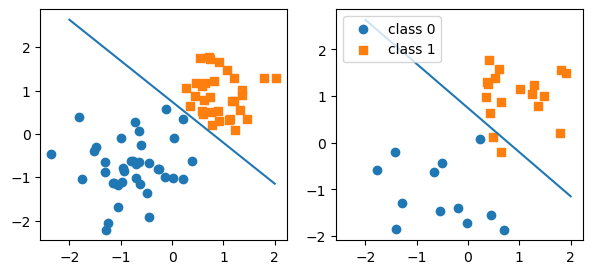

In [33]:
#########################
## 2D Decision Boundary
#########################
w , b = ppn.weights , ppn.bias

#To draw decision lines 
x_min = -2 
y_min = ( (-(w[0] *x_min) - b[0] )/ w[1])

x_max = 2 
y_max =  ( (-(w[0] *x_max) - b[0] )/ w[1])


#Divide panel into two parts
fig , ax = plt.subplots( 1 , 2, sharex = True , figsize =( 7 ,3))

#Left side : Plot for training data 
ax[0].plot([x_min , x_max] , [y_min , y_max])
ax[0].scatter(X_train[ y_train==0 , 0] , X_train[y_train ==0 ,1] , label = 'class 0' , marker = 'o')
ax[0].scatter(X_train[y_train==1 , 0] , X_train[y_train==1 ,1] , label = 'class 1' , marker = 's')


ax[1].plot([x_min , x_max] , [y_min , y_max])
ax[1].scatter(X_test[y_test ==0 , 0] , X_test[y_test ==0 ,1] , label = 'class 0' , marker = 'o')
ax[1].scatter(X_test[y_test==1 , 0] ,X_test[y_test ==1 , 1] , label = 'class 1' , marker = 's')

ax[1].legend( loc = 'upper left')
plt.show()
